## Network-based analysis

In [1]:
import sys; sys.path.append('../util')
from load_yelp_data import load_yelp_dataframe, restaurants_and_bars_in, train_test_split_reviews
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
%matplotlib inline
import networkx as nx
import random
import scipy.stats

## Load and clean data
We selected top-100 reviewed restaurants and bars in Phoenix.

In [2]:
#Load data
businesses = load_yelp_dataframe('businesses')
reviews = load_yelp_dataframe('reviews')
users = load_yelp_dataframe('users')

phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)


In [3]:
##Clean and merge businesses data with reviews data
#Rename duplicated column names between businesses and reviews datasets
phoenix_restaurants = phoenix_restaurants.rename(columns = {'stars': 'stars_business'})

#Merge with the reviews dataset
restaurants_reviews = phoenix_reviews.merge(phoenix_restaurants, how='inner', on='business_id') 

#When users reviewed a business more than once, take the most updated review result
restaurants_reviews = restaurants_reviews.sort_values(by=['year', 'month', 'day'], ascending=True, axis=0)
restaurants_reviews_nodup = restaurants_reviews.drop_duplicates(subset=('user_id', 'business_id'), keep='last')

In [4]:
#Create train and test sets
#Output: correlation matrix and top100 business_ids in each column for train and test sets
def train_and_test(df):
    #Slect top 100 frequently rated restaurants
    df100count = df['business_id'].value_counts()[:100]
    df100id = df100count.index
    mask = df['business_id'].isin(df100id)
    df100 = df[mask]

    n, m = df100.shape
    train = df100.sample(n=int(0.7*n), replace=False, random_state=1000)
    test = df100.drop(train.index)
    
    #Drop unnecessary variables
    train2 = train[['user_id', 'business_id', 'stars']]
    test2 = test[['user_id', 'business_id', 'stars']]
    
    #Create correlation matrix of star rating for train and test sets
    train_t = train2.pivot(index='user_id', columns='business_id', values='stars')
    train_corr_matrix = train_t.corr(method='spearman')
    #train_corr_matrix_values = train_corr_matrix.reset_index().values

    test_t = test2.pivot(index='user_id', columns='business_id', values='stars')
    test_corr_matrix = test_t.corr(method='spearman')
    #test_corr_matrix_values = test_corr_matrix.reset_index().values
    
    return train_corr_matrix, train, test_corr_matrix, test

PH_train, PH_train100, PH_test, PH_test100 = train_and_test(restaurants_reviews_nodup)

## Construct a network in the training set
Based on spearman's ranked correlation analyses, we constructed a correlation network of restaurants in Phoenix. Nodes are restaurants located in the axises using latitude and longitude. The red edge represents positive correlation, and blue edge is a negative correlation. 

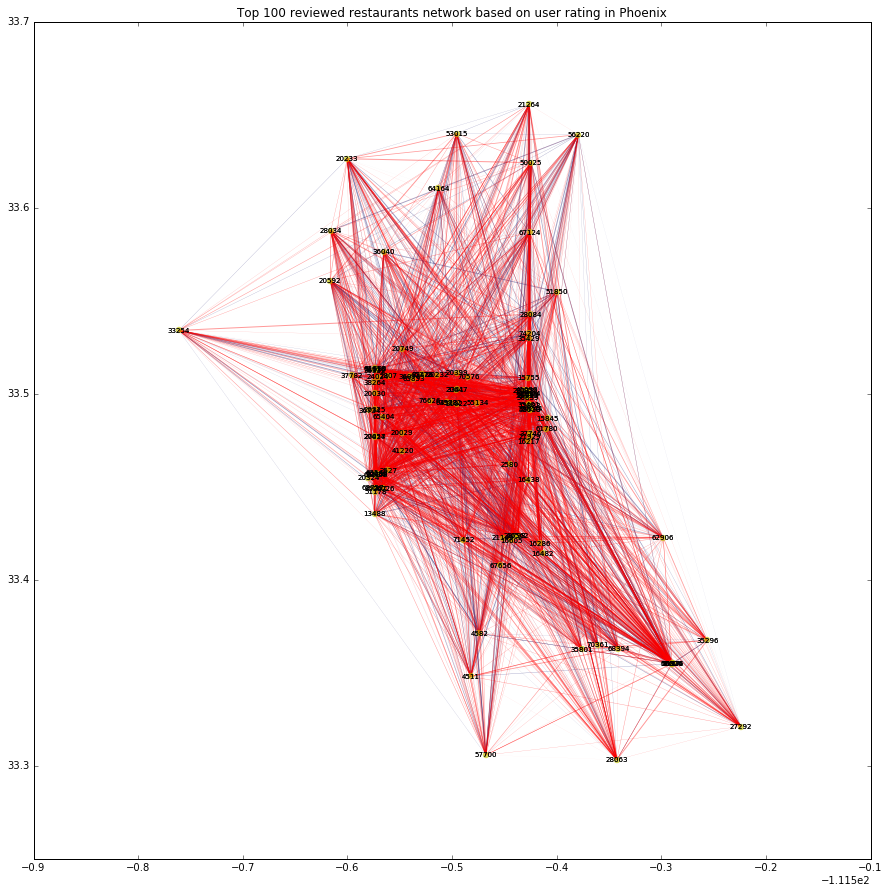

In [5]:
##Construct Phoenix network using top 100 reviewed restaurants in the train set
#Create position for the network
posx = []
for i in range(0, PH_train100.shape[0]):
    posx.append((PH_train100.iloc[i, 1], [PH_train100.iloc[i, 12], PH_train100.iloc[i, 11]]))#business id, longitude, latitude

position_dic = dict(posx)

node0=[]
node1=[]
weight0=[]
weight1=[]
columns=PH_train.columns.values
PHcorr_matrix_values = PH_train.reset_index().values
for i, line in enumerate(PHcorr_matrix_values):
    tokens=PHcorr_matrix_values[i]
    row=tokens[0]
    for column, cell in zip(columns[i:],tokens[i+1:]):
        if (cell != "") and (float(cell) < 0):
            node0.append(( int(row), int(column) ))
            weight0.append(float(cell))
        elif (cell != "") and (float(cell) > 0):
            node1.append(( int(row), int(column) ))
            weight1.append(float(cell))

#remove self-edge
node1 = [x for x in node1 if x[0] != x[1]]
            
G0=nx.Graph()
G0.add_nodes_from(columns)
G0.add_edges_from(node0)
G1=nx.Graph()
G1.add_nodes_from(columns)
G1.add_edges_from(node1)

weight0x=[i for i in weight0]
weight1x=[i*(-1) for i in weight1]

plt.figure(figsize=(15, 15))
plt.title('Top 100 reviewed restaurants network based on user rating in Phoenix')
nx.draw_networkx(G0, position_dic, width=weight0x, edge_color='midnightblue', node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
nx.draw_networkx(G1, position_dic, width=weight1x, edge_color='r',            node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
plt.show()

Number of nodes: 100
Number of total edges: 4533
Median degree: 93.0


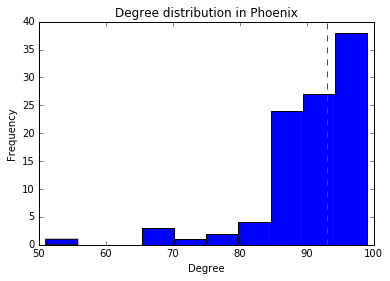

In [6]:
##Network characteristics
# Negative and positive network combined
G01=nx.Graph()
G01.add_nodes_from(columns)
node=[]
node=list(node0 + node1)
weight=list(weight0 + weight1)
G01.add_edges_from(node)

#Number of nodes
print 'Number of nodes:', len(G01.nodes())

#Number of edges
print 'Number of total edges:', len(G01.edges()) 

#Median degree
median_degree_LV = np.median(G01.degree().values())
print 'Median degree:', median_degree_LV

#Degree distribution
plt.title('Degree distribution in Phoenix')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.hist(G01.degree().values())
plt.axvline(median_degree_LV, color='r', linestyle='dashed', linewidth=1)
plt.show()

## Eigenvector centrality
To know the highly connected restaurants, we calculated eigenvector centrality in the combined positive and negative network. The eigenvector centrality is one of the popular methods to know the importance of a nodes (e.g., a hub or popularity) within a network. Briefly, it assigns a relative score to each node, and the score is calculated based on how many edges the node has as well as how many edges its neighboring nodes have. Here the neighboring nodes represent nodes that are adjacent to the node. Thus, the eigenvector centrality takes into accout the popularity of the restaurants itself as well as the popularity of the restaurants that are reviewed together. The top 95% highly connected restaurants are shown in the following table.

In [7]:
# Eigenvector centrality #
eigen_hubs=[]
for nodea in G01.nodes():
    if nx.eigenvector_centrality(G01)[nodea] >= np.percentile(nx.eigenvector_centrality(G01).values(), 95):
        eigen_hubs.append(nodea) 
print "Business IDs for popular restaurants:\n", eigen_hubs    

Business IDs for popular restaurants:
[20026, 63548, 13488, 20325, 38264, 20399, 24024]


In [28]:
#To 95% highly connected restaurants
highly_connected = phoenix_restaurants[(phoenix_restaurants['business_id']==20026) | (phoenix_restaurants['business_id']==63548)| (phoenix_restaurants['business_id']==13488) | (phoenix_restaurants['business_id']==20325) | (phoenix_restaurants['business_id']==38264) | (phoenix_restaurants['business_id']==20399) | (phoenix_restaurants['business_id']==24024)][['attributes', 'categories', 'hours', 'open', 'review_count', 'stars_business']]
columns = ['name','categories','review_count','avg_stars']
these_reviews = reviews[reviews.business_id.isin(highly_connected.index)]
avg_stars = these_reviews[['business_id','stars']].groupby('business_id').mean()
h_c = phoenix_restaurants[phoenix_restaurants.index.isin(highly_connected.index)]
h_c['avg_stars'] = avg_stars
h_c[columns].head(5)

/Users/nickhoernle/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,name,categories,review_count,avg_stars
13488,Lo-Lo's Chicken & Waffles,"['Soul Food', 'Waffles', 'Southern', 'Restaura...",1218,3.992793
20026,Pizzeria Bianco,"['Italian', 'Pizza', 'Sandwiches', 'Restaurants']",1743,3.901141
20325,FEZ,"['Bars', 'Mediterranean', 'Nightlife', 'Lounge...",1093,4.155303
20399,Chelsea's Kitchen,"['American (Traditional)', 'Restaurants']",987,4.122492
24024,St. Francis Restaurant,"['American (New)', 'Restaurants']",1154,3.967682


## Negative correlation network
Here we show a subset of the network that only includes negatively correlated edges.

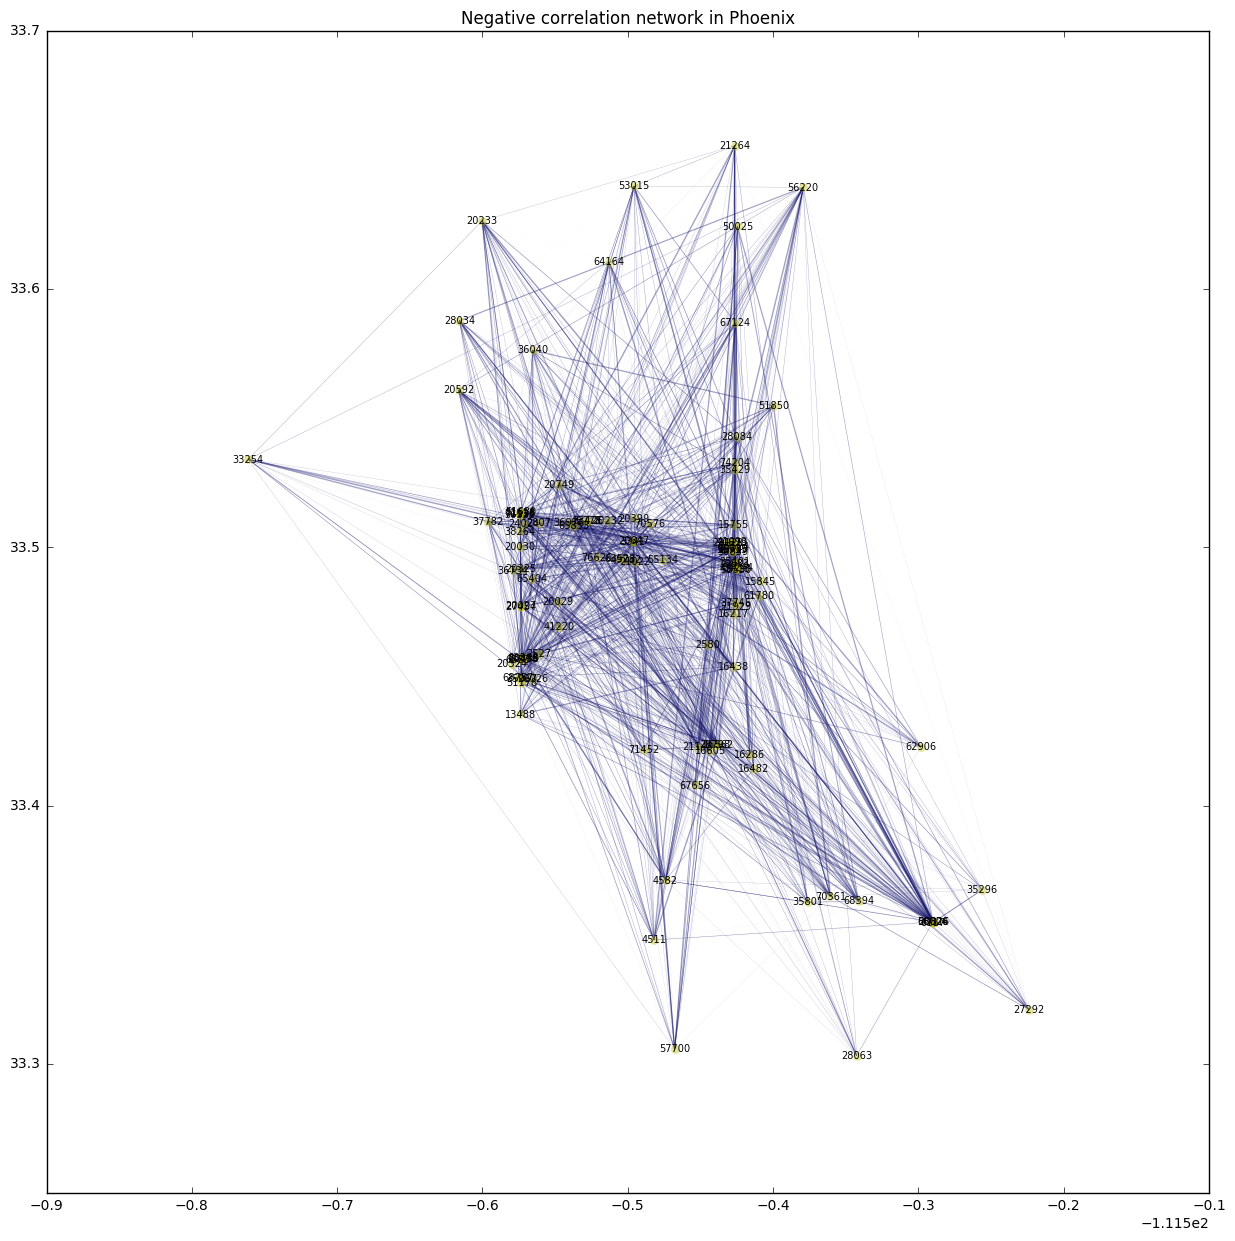

In [12]:
## Negative correlation network
plt.figure(figsize=(15, 15))
plt.title('Negative correlation network in Phoenix')
nx.draw_networkx(G0, position_dic, width=weight0x, edge_color='midnightblue', node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
plt.show()

Number of nodes: 100
Number of total edges: 1421
Median degree: 28.0


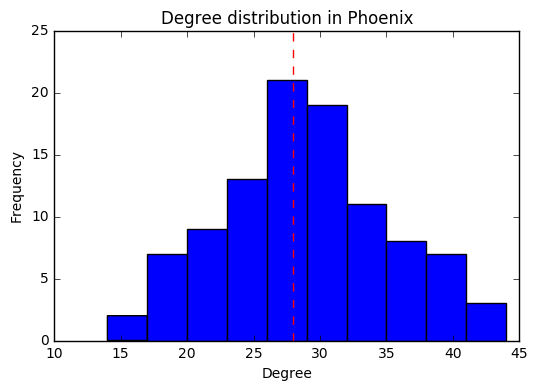

In [18]:
##Network characteristics
#Number of nodes
print 'Number of nodes:', len(G0.nodes())

#Number of edges
print 'Number of total edges:', len(G0.edges()) 

#Median degree
median_degree_PH = np.median(G0.degree().values())
print 'Median degree:', median_degree_PH

#Degree distribution
plt.title('Degree distribution in Phoenix')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.hist(G0.degree().values())
plt.axvline(median_degree_PH, color='r', linestyle='dashed', linewidth=1)
plt.show()

## Postive correlation network
Here we show a subset of the network that only includes positively correlated edges.

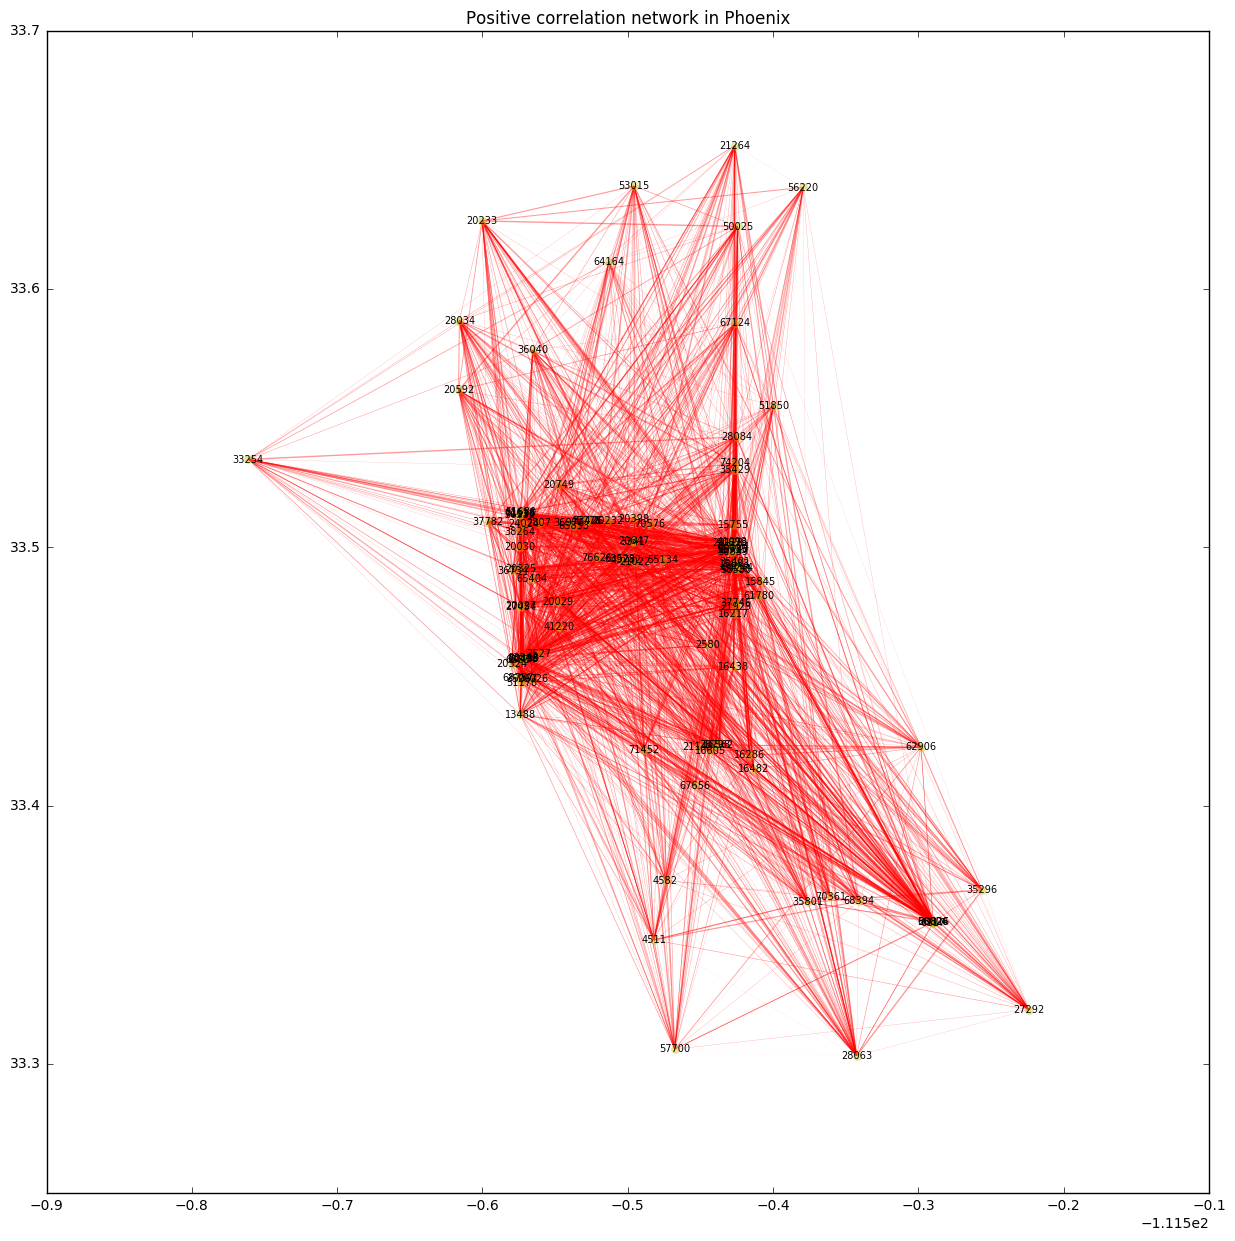

In [10]:
plt.figure(figsize=(15, 15))
plt.title('Positive correlation network in Phoenix')
nx.draw_networkx(G1, position_dic, width=weight1x, edge_color='r',            node_color='y', node_size=40, linewidths=0, alpha=0.4, font_size=7)
plt.show()

Number of nodes: 100
Number of total edges: 3112
Median degree: 63.0


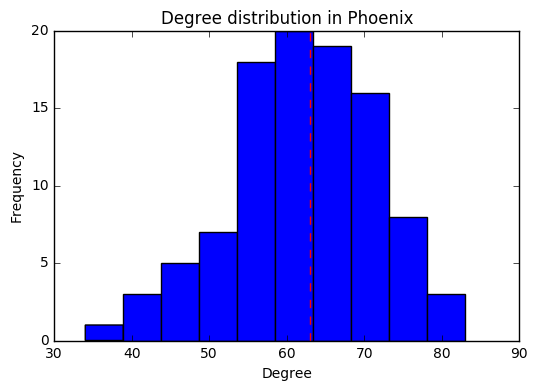

In [11]:
##Network characteristics
#Number of nodes
print 'Number of nodes:', len(G1.nodes())

#Number of edges
print 'Number of total edges:', len(G1.edges()) 

#Median degree
median_degree_PH = np.median(G1.degree().values())
print 'Median degree:', median_degree_PH

#Degree distribution
plt.title('Degree distribution in Phoenix')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.hist(G1.degree().values())
plt.axvline(median_degree_PH, color='r', linestyle='dashed', linewidth=1)
plt.show()

## PageRank to infer the important restaurants
PageRank is an algorithm to rank the importance of nodes in a network. Similar to the eigenvector centrality described above, the method takes into account the popularity of the neighboring nodes.

In [8]:
##Rank all businesses using PageRank and weight

pr = nx.pagerank(G01, weight='weight')

#Convert percentage to 1-5 values based on the star distribution percentile
for x, y in pr.items():
    if pr[x] >= np.percentile( pr.values(), float(PH_train100['stars'].value_counts()[:1] / PH_train100.shape[0])*100 ): 
        pr[x] = 5 
    elif pr[x] >= np.percentile( pr.values(), float(PH_train100['stars'].value_counts()[1:2] / PH_train100.shape[0])*100 ): 
        pr[x] = 4
    elif pr[x] >= np.percentile( pr.values(), float(PH_train100['stars'].value_counts()[2:3] / PH_train100.shape[0])*100 ): 
        pr[x] = 3
    elif pr[x] >= np.percentile( pr.values(), float(PH_train100['stars'].value_counts()[3:4] / PH_train100.shape[0])*100 ): 
        pr[x] = 2
    else:
        pr[x] = 1

## Compare stars in the test set

In [9]:
pred_PH = []
for i in PH_test100['business_id']:
    pred_PH.append(pr[i])

stars_PH = PH_test100['stars']

N = PH_test100.shape[0]
RSS = np.sum( (pred_PH - stars_PH)**2 )
RSE = np.sqrt( RSS / (N-2))

print "Average deviation of the response from the true value, RSE", RSE

Average deviation of the response from the true value, RSE 1.73205080757
